In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime
import pandas as pd
import copy
import time
import geemap
from geemap import ml
import ee

from scipy.ndimage import uniform_filter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, f1_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

#%%
# # Trigger the authentication flow.
# ee.Authenticate()

# # Initialize the library.
# ee.Initialize()

#%%
save = 0 

# define training folder path
training_folder_path = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA","training_data",'S2')
#training_folder_path = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA","training_data","old")

df_1 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20190901T200911_021904_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_2 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20200909T194951_027252_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_3 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20210829T211521_032315_N03_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_4 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20220810T213541_037263_N04_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_5 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20220918T202121_037820_N04_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_6 = pd.read_csv(os.path.join(training_folder_path,'GS2B_20190822T210029_012853_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_7 = pd.read_csv(os.path.join(training_folder_path,'GS2B_20200822T212529_018087_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_8 = pd.read_csv(os.path.join(training_folder_path,'GS2B_20210815T204019_023206_N03_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))

dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
# print(df_1.columns)

#%%

for i in range(len(dfs)):
    dfs[i]['image'] = i
df_all = pd.concat(dfs)
# print('Observations')
# print('Snow:', len(df_master[df_master['type']==1]))
# print('Firn:', len(df_master[df_master['type']==2]))
# print('Ice: ', len(df_master[df_master['type']==3]))

In [1]:
print(0)

0


In [9]:
# # subsample per image to equal number of snow/ice/firn obs
# balance = 0

# df_master_balanced = []
# c=0
# for d in dfs:
    
#     if balance:
#         firn = d[d['type']==2]
#         count = firn.shape[0]
#         snow = d[d['type']==1].sample(n=count, random_state=970)
#         ice = d[d['type']==3].sample(n=count, random_state=970)
#         rock = d[d['type']==4].sample(n=count, random_state=970)
#         shadow = d[d['type']==5].sample(n=count, random_state=970)
#         water = d[d['type']==6].sample(n=count, random_state=970)
#         bal_df = pd.concat([firn, snow, ice, rock, shadow, water])
#     else:
#         bal_df = d
    
#     bal_df['image'] = c
#     df_master_balanced.append(bal_df)
#     c+=1
    
# df_master_balanced = pd.concat(df_master_balanced)
# df_master_balanced = df_master_balanced.apply(pd.to_numeric)


# rename bands
bands_orig = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
              'SO_B1', 'SO_B2', 'SO_B3', 'SO_B4', 'SO_B5', 'SO_B6', 'SO_B7', 'SO_B8', 'SO_B8A', 'SO_B9', 'SO_B11', 'SO_B12']
bands_new = ['coastal', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'vapor', 'swir1', 'swir2',
             'SO_coastal', 'SO_blue', 'SO_green', 'SO_red', 'SO_re1', 'SO_re2', 'SO_re3', 'SO_nir', 'SO_re4', 'SO_vapor', 'SO_swir1', 'SO_swir2']
bands_raw = ['coastal', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'vapor', 'swir1', 'swir2', 'ndwi', 'ndsi']

bands_dict = {bands_orig[i]:bands_new[i] for i in range(len(bands_orig))}
df_all = df_all.rename(columns=bands_dict)

# add ndsi, ndwi, dn
df_all['ndwi'] = (df_all['green']-df_all['nir'])/(df_all['green']+df_all['nir'])
df_all['SO_ndwi'] = (df_all['SO_green']-df_all['SO_nir'])/(df_all['SO_green']+df_all['SO_nir'])
df_all['ndsi'] = (df_all['green']-df_all['swir1'])/(df_all['green']+df_all['swir1'])
df_all['SO_ndsi'] = (df_all['SO_green']-df_all['SO_swir1'])/(df_all['SO_green']+df_all['SO_swir1'])
df_all['B8B9'] = (df_all['re4']-df_all['vapor'])/(df_all['re4']+df_all['vapor'])

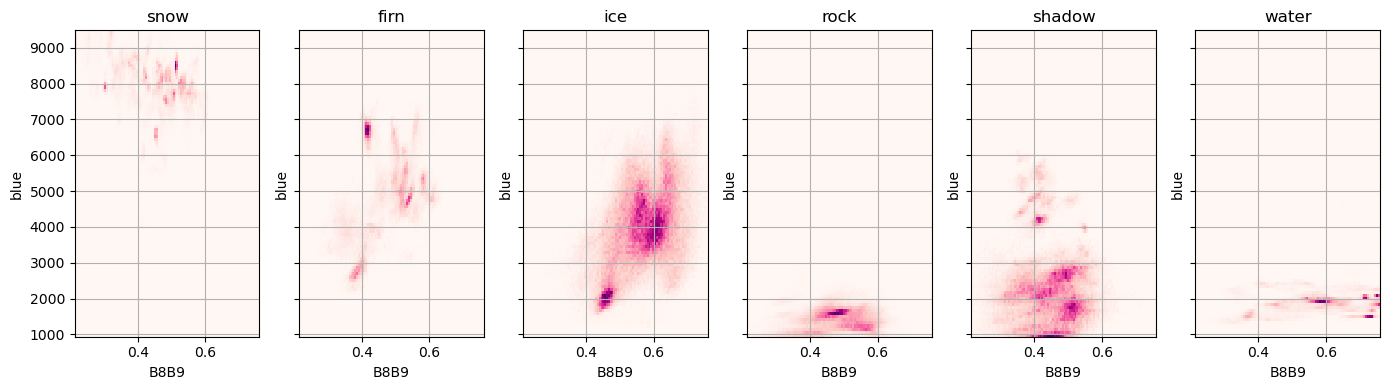

In [10]:
# df_all['nir2swir'] = (df_all['nir']*df_all['nir'])/(df_all['swir1'])
# df_all['SO_nir2swir'] = (df_all['SO_nir']*df_all['SO_nir'])/(df_all['SO_swir1'])


for i in bands_raw:
    df_all[f"DN_{i}"] = df_all[f"{i}"]/df_all[f"SO_{i}"]

# remove bad data
df_all = df_all.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

#%%
## quick figure to investigate the spectral differences of each class
titles = ['snow', 'firn', 'ice', 'rock', 'shadow', 'water']
x_var = 'B8B9'
y_var = 'blue'

x_range = np.nanpercentile(df_all[x_var], [1,99])
y_range = np.nanpercentile(df_all[y_var], [1,99])
all_range = [x_range,y_range]

fig, axs = plt.subplots(1,6, figsize=(14,4), sharex=True, sharey=True)
for surface in [0,1,2,3,4,5]:
    ax = axs[surface]
    subset = df_all[df_all['type']==surface+1]
    
    # ax.scatter(subset[x_var], subset[y_var], c=colors_to_use[surface])
    ax.hist2d(subset[x_var], subset[y_var], bins=100, density=False, range=all_range, cmap='RdPu')
    
    ax.set_title(titles[surface])
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.grid()
plt.tight_layout()